In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [4]:
import os
import gym
import random
import numpy as np
import tensorflow as tf
from collections import deque
from skimage.color import rgb2gray
from skimage.transform import resize
from scipy.signal import savgol_filter
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D

from IPython import display
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [5]:
env_name = 'Seaquest-v0'  # Environment name

# Parameters

In [6]:
frame_width = 128 # Resized frame width
frame_height = 128  # Resized frame height
state_len = 4  # Number of most recent frames to produce the input to the network

num_episodes = 50  # Number of episodes the agent plays

gamma = 0.99  # Discount factor

initial_espilon= 1.0  # Initial value of epsilon in epsilon-greedy
min_esp = 0.1  # Final value of epsilon in epsilon-greedy

initial_replay_size = 1e4  # Number of steps to populate the replay memory before training starts
num_replay_memory = 5e4  # Number of replay memory the agent uses for training

bs = 64  # Mini batch size
trgt_intvl_updt = 1e4  # The frequency with which the target network is updated

trn_intvl = 4  # The agent selects 4 actions between successive updates

lr = 0.0003  # Learning rate 
min_grad= 0.01  # Constant added to the squared gradient in the denominator of the update

NoUpdt_steps = 4 # Maximum number of "do nothing" actions to be performed by the agent at the start of an episode

test_num_episodes = 30  # Number of episodes the agent plays at test time

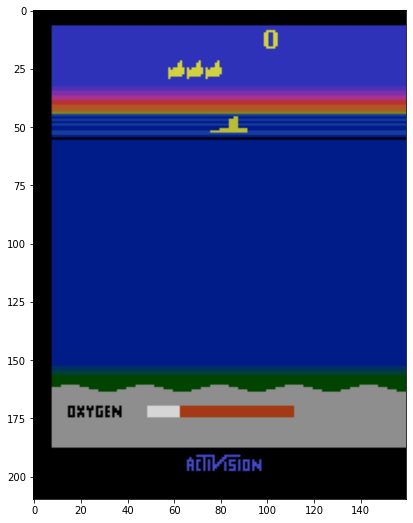

In [7]:
env = gym.make(env_name)
env.reset()
plt.figure(figsize=(9,9))
img = plt.imshow(env.render(mode='rgb_array')) 
for _ in range(10):
    img.set_data(env.render(mode='rgb_array')) 
    display.display(plt.gcf())
    display.clear_output(wait=True)
    action = env.action_space.sample()
    env.step(action)
env.close()

In [8]:
class DDQNAgent():
    def __init__(self, num_actions):
        self.num_actions = num_actions
        self.epsilon = initial_espilon
        self.epsilon_step = (initial_espilon - min_esp) * 1e-6
        self.t = 0

        # Parameters used for summary
        self.total_reward = 0
        self.total_q_max = 0
        self.total_loss = 0
        self.duration = 0
        self.episode = 0

        # Create replay memory
        self.replay_memory = deque()
        # Ceate history for plotting
        self.stat_history=[]

        # Create q network
        self.s, self.q_values, q_network = self.make_network()
        q_network_weights = q_network.trainable_weights

        # Create target network
        self.st, self.target_q_values, target_network = self.make_network()
        target_network_weights = target_network.trainable_weights

        # Define target network update operation
        self.update_target_network = [target_network_weights[i].assign(q_network_weights[i]) for i in range(len(target_network_weights))]

        # Define loss and gradient update operation
        self.a, self.y, self.loss, self.grads_update = self.build_training_op(q_network_weights)

        self.sess = tf.InteractiveSession()
        self.saver = tf.train.Saver(q_network_weights)
       
        self.sess.run(tf.initialize_all_variables())

        # Initialize target network
        self.sess.run(self.update_target_network)

    def make_network(self):
        model = Sequential()
        model.add(Conv2D(32, (8, 8), subsample=(4, 4), activation='relu', 
                                input_shape=(state_len, frame_width, frame_height),
                                data_format="channels_first", padding='same'))
        #model.add(MaxPooling2D(pool_size=(2, 2))) # blew up do not use
        model.add(Dropout(0.05))
        model.add(Conv2D(64, (4, 4), subsample=(2, 2), activation='relu', padding='same'))
        #model.add(MaxPooling2D(pool_size=(2, 2))) # blew up not not use
        model.add(Dropout(0.05))
        model.add(Conv2D(128, (3, 3), subsample=(1, 1), activation='relu', padding='same'))
        #model.add(MaxPooling2D(pool_size=(2, 2))) # blew up not not use
        model.add(Dropout(0.05))
        model.add(Flatten())
        model.add(Dense(512, activation='relu'))
        model.add(Dense(self.num_actions))

        s = tf.placeholder(tf.float32, [None, state_len, frame_width, frame_height])
        q_values = model(s)

        return s, q_values, model

    def build_training_op(self, q_network_weights):
        a = tf.placeholder(tf.int64, [None])
        y = tf.placeholder(tf.float32, [None])

        # Convert action to one hot vector
        a_one_hot = tf.one_hot(a, self.num_actions, 1.0, 0.0)
        q_value = tf.reduce_sum(tf.multiply(self.q_values, a_one_hot), reduction_indices=1)

        # Clip the error, the loss is quadratic when the error is in (-1, 1), and linear outside of that region
        error = tf.abs(y - q_value)
        quadratic_part = tf.clip_by_value(error, 0.0, 1.0)
        linear_part = error - quadratic_part
        loss = tf.reduce_mean(0.5 * tf.square(quadratic_part) + linear_part)

        optimizer = tf.train.AdamOptimizer(lr, epsilon=min_grad)
        grads_update = optimizer.minimize(loss, var_list=q_network_weights)

        return a, y, loss, grads_update

    def get_initial_state(self, observation, last_observation):
        processed_observation = np.maximum(observation, last_observation)
        processed_observation = np.uint8(resize(rgb2gray(processed_observation), (frame_width, frame_height)) * 255)
        state = [processed_observation for _ in range(state_len)]
        return np.stack(state, axis=0)

    def get_action(self, state):
        if self.epsilon >= random.random() or self.t < initial_replay_size:
            action = random.randrange(self.num_actions)
        else:
            action = np.argmax(self.q_values.eval(feed_dict={self.s: [np.float32(state / 255.0)]}))

        # Anneal epsilon linearly over time
        if self.epsilon > min_esp and self.t >= initial_replay_size:
            self.epsilon -= self.epsilon_step

        return action

    def run(self, state, action, reward, terminal, observation):
        next_state = np.append(state[1:, :, :], observation, axis=0)

        # Clip all positive rewards at 1 and all negative rewards at -1, leaving 0 rewards unchanged
        reward = np.clip(reward, -1, 1)

        # Store transition in replay memory
        self.replay_memory.append((state, action, reward, next_state, terminal))
        if len(self.replay_memory) > num_replay_memory:
            self.replay_memory.popleft()

        if self.t >= initial_replay_size:
            # Train network
            if self.t % trn_intvl == 0:
                self.train_network()

            # Update target network
            if self.t % trgt_intvl_updt == 0:
                self.sess.run(self.update_target_network)

        self.total_reward += reward
        self.total_q_max += np.max(self.q_values.eval(feed_dict={self.s: [np.float32(state / 255.0)]}))
        self.duration += 1

        if terminal:
            print('Episode: {0:3d} Timestep: {1:5d} Duration: {2:3d} Epsilon: {3:.5f} Total_reward: {4:3.0f} Avg_max_Q: {5:2.4f} Avg_loss: {6:.5f}'.format(
                self.episode + 1, self.t, self.duration, self.epsilon,
                self.total_reward, self.total_q_max / float(self.duration),
                self.total_loss / (float(self.duration) / float(trn_intvl))))
            
            self.stat_history.append([self.episode + 1, self.t, self.duration, self.epsilon,
                self.total_reward, self.total_q_max / float(self.duration),
                self.total_loss / (float(self.duration) / float(trn_intvl))])

            self.total_reward = 0
            self.total_q_max = 0
            self.total_loss = 0
            self.duration = 0
            self.episode += 1

        self.t += 1

        return next_state

    def train_network(self):
        state_batch = []
        action_batch = []
        reward_batch = []
        next_state_batch = []
        terminal_batch = []
        y_batch = []

        # Sample random minibatch of transition from replay memory
        minibatch = random.sample(self.replay_memory, bs)
        for data in minibatch:
            state_batch.append(data[0])
            action_batch.append(data[1])
            reward_batch.append(data[2])
            next_state_batch.append(data[3])
            terminal_batch.append(data[4])

        # Convert True to 1, False to 0
        terminal_batch = np.array(terminal_batch) + 0

        next_action_batch = np.argmax(self.q_values.eval(feed_dict={self.s: next_state_batch}), axis=1)
        target_q_values_batch = self.target_q_values.eval(feed_dict={self.st: next_state_batch})
        for i in range(len(minibatch)):
            y_batch.append(reward_batch[i] + (1 - terminal_batch[i]) * gamma * target_q_values_batch[i][next_action_batch[i]])

        loss, _ = self.sess.run([self.loss, self.grads_update], feed_dict={
            self.s: np.float32(np.array(state_batch) / 255.0),
            self.a: action_batch,
            self.y: y_batch
        })

        self.total_loss += loss

    def get_action_at_test(self, state):
        action = np.argmax(self.q_values.eval(feed_dict={self.s: [np.float32(state / 255.0)]}))
        self.t += 1

        return action

In [9]:
def preprocess(observation, last_observation):
    processed_observation = np.maximum(observation, last_observation)
    processed_observation = np.uint8(resize(rgb2gray(processed_observation), (frame_width, frame_height)) * 255)
    return np.reshape(processed_observation, (1, frame_width, frame_height))

In [10]:
env = gym.make(env_name)
agent = DDQNAgent(num_actions=env.action_space.n)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/home/stev/anaconda3/envs/DeepRL/lib/python3.6/site-packages/ipykernel_launcher.py:46: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (8, 8), activation="relu", input_shape=(4, 128, 1..., data_format="channels_first", padding="same", strides=(4, 4))`
/home/stev/anaconda3/envs/DeepRL/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (4, 4), activation="relu", padding="same", strides=(2, 2))`
/home/stev/anaconda3/envs/DeepRL/lib/python3.6/site-packages/ipykernel_launcher.py:52: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", padding="same", strides=(1, 1))`


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.global_variables_initializer` instead.


# Train mode

In [11]:
for _ in range(num_episodes):
    terminal = False
    observation = env.reset()
    for _ in range(random.randint(1, NoUpdt_steps)):
        last_observation = observation
        observation, _, _, _ = env.step(0)  # Do nothing
    state = agent.get_initial_state(observation, last_observation)
    while not terminal:
        last_observation = observation
        action = agent.get_action(state)
        observation, reward, terminal, _ = env.step(action)

        processed_observation = preprocess(observation, last_observation)
        state = agent.run(state, action, reward, terminal, processed_observation)

Episode:   1 Timestep:   583 Duration: 584 Epsilon: 1.00000 Total_reward:   3 Avg_max_Q: 0.0669 Avg_loss: 0.00000
Episode:   2 Timestep:  1253 Duration: 670 Epsilon: 1.00000 Total_reward:   3 Avg_max_Q: 0.0680 Avg_loss: 0.00000
Episode:   3 Timestep:  2070 Duration: 817 Epsilon: 1.00000 Total_reward:   4 Avg_max_Q: 0.0676 Avg_loss: 0.00000
Episode:   4 Timestep:  2967 Duration: 897 Epsilon: 1.00000 Total_reward:   4 Avg_max_Q: 0.0670 Avg_loss: 0.00000
Episode:   5 Timestep:  3551 Duration: 584 Epsilon: 1.00000 Total_reward:   5 Avg_max_Q: 0.0678 Avg_loss: 0.00000
Episode:   6 Timestep:  4119 Duration: 568 Epsilon: 1.00000 Total_reward:   3 Avg_max_Q: 0.0673 Avg_loss: 0.00000
Episode:   7 Timestep:  4972 Duration: 853 Epsilon: 1.00000 Total_reward:   6 Avg_max_Q: 0.0683 Avg_loss: 0.00000
Episode:   8 Timestep:  5502 Duration: 530 Epsilon: 1.00000 Total_reward:   2 Avg_max_Q: 0.0668 Avg_loss: 0.00000
Episode:   9 Timestep:  6229 Duration: 727 Epsilon: 1.00000 Total_reward:   4 Avg_max_Q:

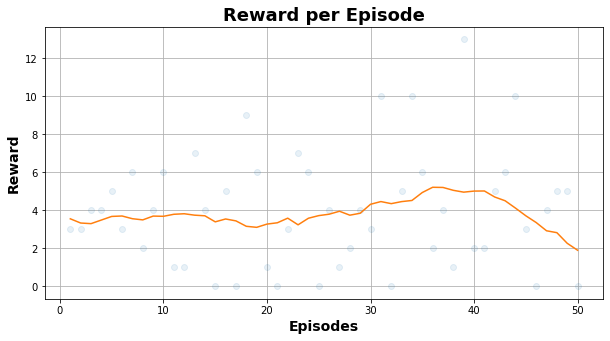

In [12]:
data=np.array(agent.stat_history)
x=data[:,0]
y=data[:,4]

y_trend=savgol_filter(y, 33, 3, mode='nearest')

plt.figure(figsize=(10,5))
plt.plot(x,y, 'o', alpha=0.1)
plt.plot(x,y_trend, '-')
plt.ylabel('Reward',fontsize=14, fontweight='bold')
plt.xlabel('Episodes',fontsize=14, fontweight='bold')
plt.title('Reward per Episode', fontsize=18, fontweight='bold')
plt.grid()
plt.show()



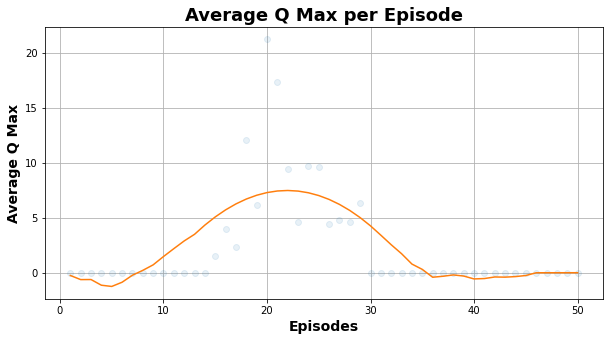

In [13]:
data=np.array(agent.stat_history)
x=data[:,0]
y=data[:,6]

y_trend=savgol_filter(y, 33, 3, mode='nearest')

plt.figure(figsize=(10,5))
plt.plot(x,y, 'o', alpha=0.1)
plt.plot(x,y_trend, '-')
plt.ylabel('Average Q Max',fontsize=14, fontweight='bold')
plt.xlabel('Episodes',fontsize=14, fontweight='bold')
plt.title('Average Q Max per Episode', fontsize=18, fontweight='bold')
plt.grid()
plt.show()

# Test mode

In [14]:
for _ in range(test_num_episodes):
    img.set_data(env.render(mode='rgb_array')) 
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    terminal = False
    observation = env.reset()
    for _ in range(random.randint(1, NoUpdt_steps)):
        last_observation = observation
        observation, _, _, _ = env.step(0)  # Do nothing
    state = agent.get_initial_state(observation, last_observation)
    while not terminal:
        last_observation = observation
        action = agent.get_action_at_test(state)
        observation, _, terminal, _ = env.step(action)
        env.render()
        processed_observation = preprocess(observation, last_observation)
        state = np.append(state[1:, :, :], processed_observation, axis=0)
env.close()

<Figure size 432x288 with 0 Axes>

In [16]:
import datetime as dt
print(f'Finished: {dt.datetime.now()}')

Finished: 2021-05-09 17:25:18.493034
